In [22]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
#%matplotlib qt
#%matplotlib notebook

In [23]:
file1 = h5py.File(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\clouds\20180908_200400_0p2a_UVIS_D.h5','r')#smooth
#file2 = h5py.File(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations\20180427_051720_1p0_UVIS_U.h5','r')#smooth
file2 = h5py.File(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations\20181201_060601_1p0_UVIS_I.h5','r')#non-smooth

In [28]:
list(file1.keys())

['ratio_blue_uv', 'ratio_red_blue', 'ratio_red_uv', 'total_signal']

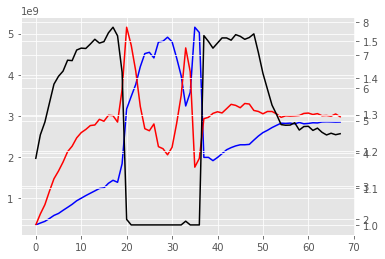

In [46]:
T1 = np.array(file1['ratio_blue_uv'])
T2 = np.array(file1['ratio_red_blue'])
T3 = np.array(file1['ratio_red_uv'])
T4 = np.array(file1['total_signal'])


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(T4,'b')
ax2.plot(T1,'r')
ax3.plot(T2,'k')
#plt.plot(T2)
#plt.plot(T3)

In [24]:
T1 = np.array(file1['Science/Transmission'])
T2 = np.array(file2['Science/Transmission'])
k = []

TangAlt1 = np.array(file1['Geometry/Point0/TangentAltSurface'])
TangAlt2 = np.array(file2['Geometry/Point0/TangentAltSurface'])

wav = np.array(file1['Science/Wavelength'])

avg_TangAlt1 = np.array([])
avg_TangAlt2 = np.array([])


for _ in range(TangAlt1.shape[0]):
    avg_TangAlt1 = np.append(avg_TangAlt1,np.mean(TangAlt1[_,:]))
    
for _ in range(TangAlt2.shape[0]):
    avg_TangAlt2 = np.append(avg_TangAlt2,np.mean(TangAlt2[_,:]))

T1_250 = T1[:,np.array(np.where(wav == min(abs(wav-250))+250)).flatten()].reshape(-1,)
T2_250 = T2[:,np.array(np.where(wav == min(abs(wav-250))+250)).flatten()].reshape(-1,)

k.append(avg_TangAlt1)
k.append(avg_TangAlt2)

KeyError: 'Unable to open object (component not found)'

In [4]:
x = T1_250
y = T2_250

if x[0] > 0.5:
    x = x[::-1]
if y[0] > 0.5:
    y = y[::-1]


#x = np.absolute(spf.fft(x))
#y = np.absolute(spf.fft(y))
z = np.array([x,y])

In [5]:
plt.plot(t_interp[1])

NameError: name 't_interp' is not defined

In [6]:
alt_interp = np.arange(0,274,1)
t_interp = []
for i in range(len(z)):
    z_interp = np.interp(alt_interp,k[i],z[i])
    t_interp.append(z_interp)
t_interp = np.array(t_interp)
t_interp[t_interp < 0] = 0.0001

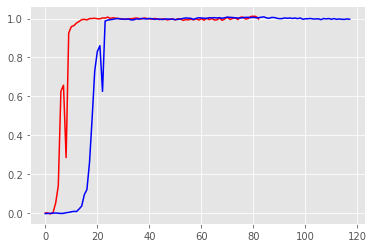

In [7]:
plt.plot(x,'r')
plt.plot(y,'b')
#plt.plot(avg_TangAlt1,x,'b')
#plt.plot(avg_TangAlt2,y,'r')

In [8]:
cost,path = fastdtw(x,y)
cost

1.5808605585033058

In [9]:
distances = np.zeros((len(y), len(x)))

for i in range(len(y)):
    for j in range(len(x)):
        distances[i,j] = (x[j]-y[i])**2  

In [10]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    #plt.figure()
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();

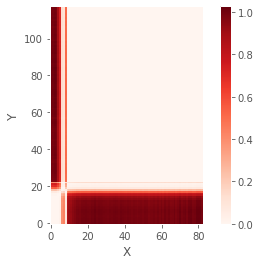

In [11]:
distance_cost_plot(distances)

In [12]:
accumulated_cost = np.zeros((len(y), len(x)))

for i in range(1, len(y)):
    for j in range(1, len(x)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

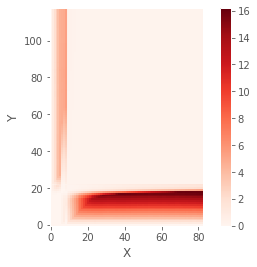

In [13]:
distance_cost_plot(accumulated_cost)

In [14]:
path = [[len(x)-1, len(y)-1]]
i = len(y)-1
j = len(x)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

In [15]:
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]

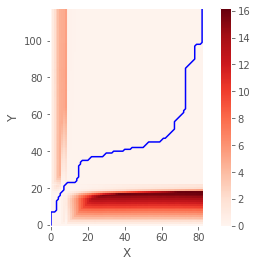

In [16]:
distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_y,'b');

In [17]:
def path_cost(x, y, accumulated_cost, distances):
    path = [[len(x)-1, len(y)-1]]
    cost = 0
    i = len(y)-1
    j = len(x)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [y, x] in path:
        cost = cost +distances[x, y]
    return path, cost   

In [18]:
path, cost = path_cost(x, y, accumulated_cost, distances)
print (path)
print (cost)

[[82, 117], [82, 116], [82, 115], [82, 114], [82, 113], [82, 112], [82, 111], [82, 110], [82, 109], [82, 108], [82, 107], [82, 106], [82, 105], [82, 104], [82, 103], [82, 102], [82, 101], [82, 100], [82, 99], [81, 98], [80, 98], [79, 98], [78, 97], [78, 96], [78, 95], [78, 94], [78, 93], [78, 92], [78, 91], [78, 90], [77, 89], [76, 88], [75, 87], [74, 86], [73, 85], [73, 84], [73, 83], [73, 82], [73, 81], [73, 80], [73, 79], [73, 78], [73, 77], [73, 76], [73, 75], [73, 74], [73, 73], [73, 72], [73, 71], [73, 70], [73, 69], [73, 68], [73, 67], [73, 66], [73, 65], [73, 64], [73, 63], [72, 62], [72, 61], [71, 60], [70, 59], [69, 58], [68, 57], [67, 56], [67, 55], [67, 54], [67, 53], [67, 52], [66, 51], [65, 50], [64, 49], [63, 48], [62, 47], [61, 47], [60, 46], [59, 45], [58, 45], [57, 45], [56, 45], [55, 45], [54, 45], [53, 45], [52, 44], [51, 43], [50, 42], [49, 42], [48, 42], [47, 42], [46, 42], [45, 42], [44, 42], [43, 41], [42, 41], [41, 41], [40, 41], [39, 40], [38, 40], [37, 40], [

[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 6), (2, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 14), (4, 15), (5, 16), (5, 17), (6, 18), (7, 19), (7, 20), (7, 21), (8, 22), (9, 23), (10, 23), (11, 23), (12, 23), (13, 23), (14, 24), (14, 25), (15, 26), (16, 26), (17, 27), (18, 28), (19, 28), (20, 28), (21, 28), (22, 28), (23, 28), (24, 28), (25, 28), (26, 28), (27, 28), (28, 28), (29, 28), (30, 28), (31, 28), (32, 28), (33, 28), (34, 28), (35, 28), (36, 28), (37, 28), (38, 28), (39, 28), (40, 29), (41, 29), (42, 29), (43, 29), (44, 30), (45, 30), (46, 31), (47, 31), (48, 31), (49, 31), (50, 31), (51, 32), (52, 32), (53, 33), (54, 34), (55, 34), (56, 34), (57, 34), (58, 35), (59, 36), (60, 37), (60, 38), (61, 39), (62, 40), (63, 41), (64, 41), (65, 42), (66, 43), (67, 44), (68, 45), (69, 46), (69, 47), (69, 48), (69, 49), (69, 50), (69, 51), (69, 52), (69, 53), (70, 54), (70, 55), (71, 56), (71, 57), (72, 58), (72, 59), (72, 60), (72, 61), (72, 62), (73, 63), (73

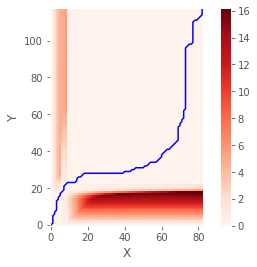

In [19]:
from fastdtw import fastdtw

cost, path = fastdtw(x,y, dist = euclidean)
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]
print(path)
distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_y,'b');

Text(0, 0.5, 'Transmission')

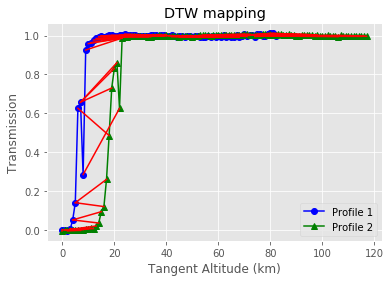

In [20]:
plt.plot(x, 'bo-' ,label='Profile 1')
plt.plot(y, 'g^-', label = 'Profile 2')
plt.legend()
paths = path_cost(x, y, accumulated_cost, distances)[0]
for [map_x, map_y] in paths:
    #print (map_x, x[map_x], ":", map_y, y[map_y])
    
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')

plt.title('DTW mapping')
plt.xlabel('Tangent Altitude (km)')
plt.ylabel('Transmission')



In [21]:
a = fastdtw(x,y,dist = euclidean)
a[0]

1.5808605585033058

In [ ]:
x1 = np.insert(x,0,[0]*10)

In [ ]:
plt.plot(x1[:30],'b')
plt.plot(y[:30],'g')

In [ ]:
cost,path = fastdtw(x1[:30],y[:30],dist ='euclidean')
cost

In [ ]:
import scipy.fftpack as spf

x_fft = np.absolute(spf.fft(x[:60]))
y_fft = np.absolute(spf.fft(y[:60]))

plt.plot(x_fft,'b')
plt.plot(y_fft,'g')

a = fastdtw(x_fft,y_fft,dist = euclidean)
a[0]


In [ ]:
x_train_file = open(r'C:\Users\kj4755\Work Folders\Downloads\UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt', 'r')
y_train_file = open(r'C:\Users\kj4755\Work Folders\Downloads\UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt', 'r')

x_test_file = open(r'C:\Users\kj4755\Work Folders\Downloads\UCI HAR Dataset\UCI HAR Dataset\test\X_test.txt', 'r')
y_test_file = open(r'C:\Users\kj4755\Work Folders\Downloads\UCI HAR Dataset\UCI HAR Dataset\test\y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
plt.plot(x_train[10])
x_train[0,0]

In [ ]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [ ]:
m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)
print(distance)